This notebook supplements the manuscript "Data-driven modeling reveals a universal dynamic underlying the COVID-19 pandemic under social distancing" by Robert Marsland III and Pankaj Mehta.

In this work, we show that the cumulative fatalities $N(t)$ for every region with more than 500 deaths as of April 15, 2020 is well-described by the function:
\begin{align}
N(t) = N_{\rm max}\Phi\left(\frac{t-t_h}{\sigma}\right),
\end{align}
where
\begin{align}
\Phi(t) &= {1 \over \sqrt{2\pi}} \int_{-\infty}^t e^{-x^2/2}\,dx
\end{align}
is the cumulative normal distribution. The same functional form provides a good fit to the cumulative number of confirmed cases for most countries with sufficient data. This model has two key parameters, the final total number of fatalities (or cases) $N_{\rm max}$, and the infection timescale $\sigma$. The third parameter $t_h$, sets the overall location of the infection curve on the time axis. 

The first cell of this notebook loads the current case and fatality data from the [Johns Hopkins github repository](https://github.com/CSSEGISandData/COVID-19) along with the best-fit values and confidence bounds for the three fitting parameters using data through April 15, 2020, and a set of functions for fitting, analyzing and simulating the data. Example code is provided for plotting the predictions, making new predictions and running simulations.

We emphasize that the confidence intervals shown here are <em>lower bounds</em> on the true amount of uncertainty. These intervals are calculated under the assumption that the data is accurately described by the fitting function given above, with no changes in parameter values, and with all deviations from this function due to random multiplicative noise. The confidence intervals <em>do not</em> account for possible future changes in social policy, or for systematic deviations from the fitting function that may arise at late times.

# Plot predictions

To plot the live data with the predictions made on April 15, replace the arguments of the "plot_region" function with the country and province/state of interest. Country-level data is accessed by using 'NaN' for the second argument. Dashed line marks April 15, the date the predictions were made.

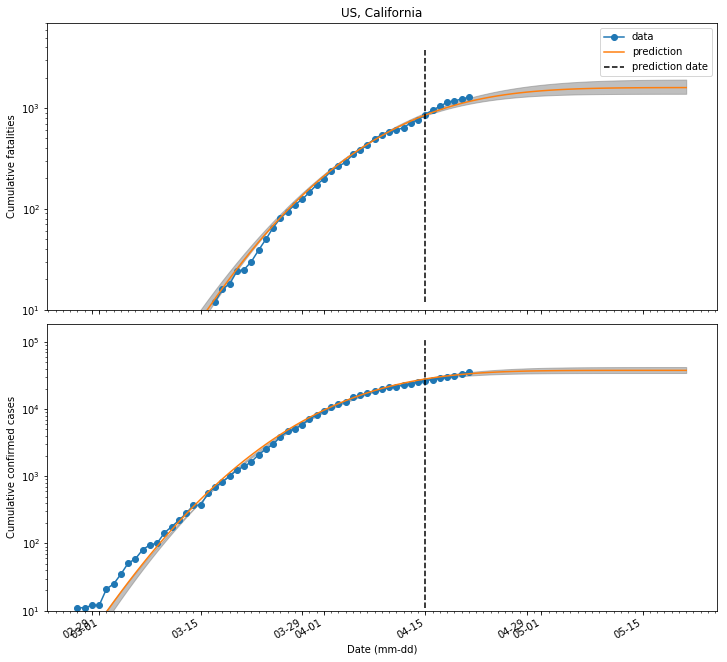

In [15]:
from covid_plotting import *
plot_region('US','California',forecast_days=30) 

Changing the horizontal axis to a log scale allows you to see the power law behavior at early times:

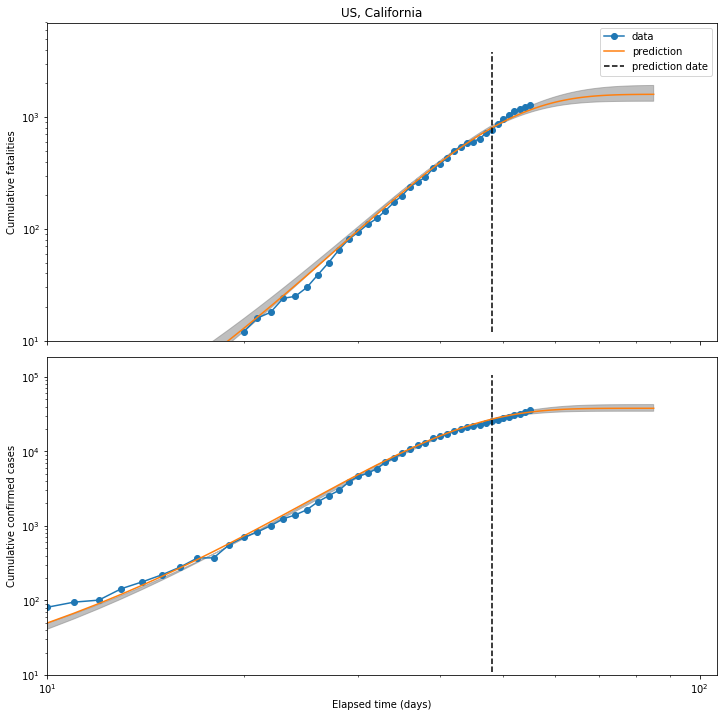

In [16]:
plot_region('US','California',forecast_days=30,log_scale=True) 

To access the parameters for a given region, replace the two strings in the cells below with the country and state/province of interest.

For fatalities, use:

In [6]:
predictions_deaths_apr15.loc['Sweden','NaN']

Nmax                      2007.23
Nmax_low                  1499.11
Nmax_high                 3433.77
sigma                     9.88884
sigma_low                 8.60252
sigma_high                11.9405
th            2020-04-12 00:00:00
th_low        2020-04-09 00:00:00
th_high       2020-04-18 00:00:00
Name: (Sweden, NaN), dtype: object

For cases, use:

In [7]:
predictions_cases_apr15.loc['Sweden','NaN']

Nmax                      49328.6
Nmax_low                  33886.3
Nmax_high                 85215.3
sigma                     21.8862
sigma_low                 19.7903
sigma_high                24.6654
th            2020-04-29 00:00:00
th_low        2020-04-21 00:00:00
th_high       2020-05-10 00:00:00
Name: (Sweden, NaN), dtype: object

The complete spreadsheets can also be downloaded from the "output" folder of [the github repository](https://github.com/Emergent-Behaviors-in-Biology/covid19).

# Make new predictions

The cell below allows you to fit the full dataset including the latest data, for all countries and regions. It generates Pandas dataframes called `params_cases` and `params_deaths`, which contain the best-fit parameter values along with the RMS deviation of the data from the fitting function in log space ("score"). These parameters can be used as the starting point for generating confidence intervals below. The parameter `p0` sets a threshold for discarding data from the beginning of the pandemic in each region, in order to focus on the later, more universal part of the curve. All timepoints with fewer cumulative cases/fatalities than `p0` are discarded for the purposes of fitting.

In [3]:
from covid_plotting import *
params_deaths = fit_all(deaths,plot=False,p0=50)
params_cases = fit_all(cases,plot=False,p0=5e2)

We can use the best-fit parameters to perform an updated data collapse:

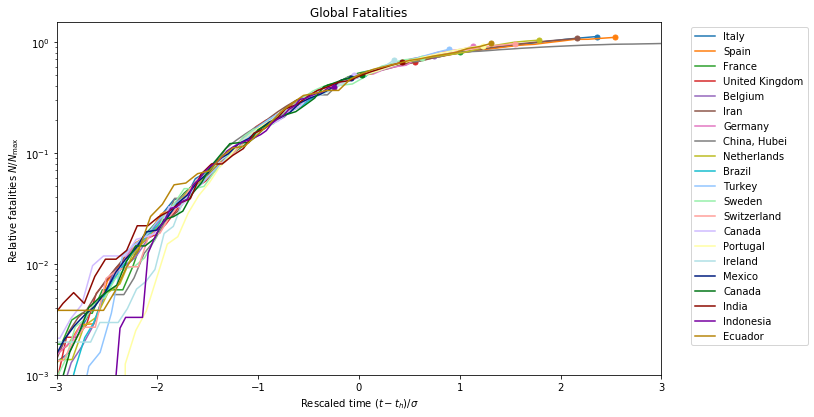

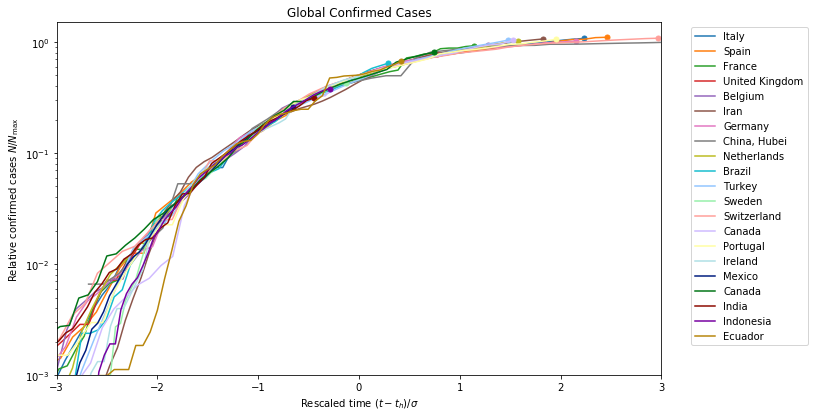

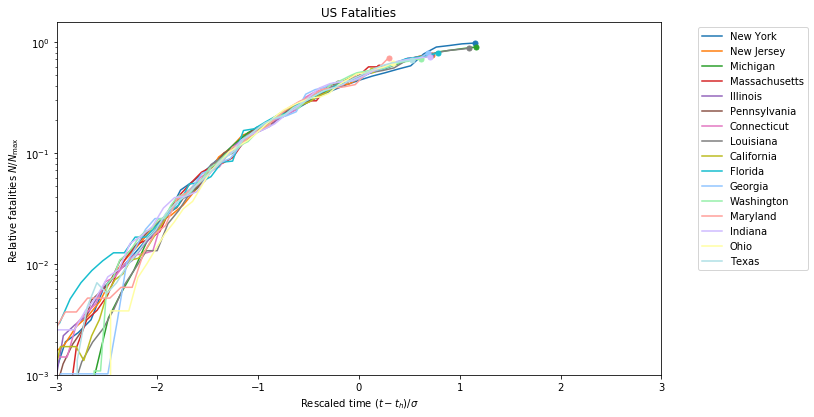

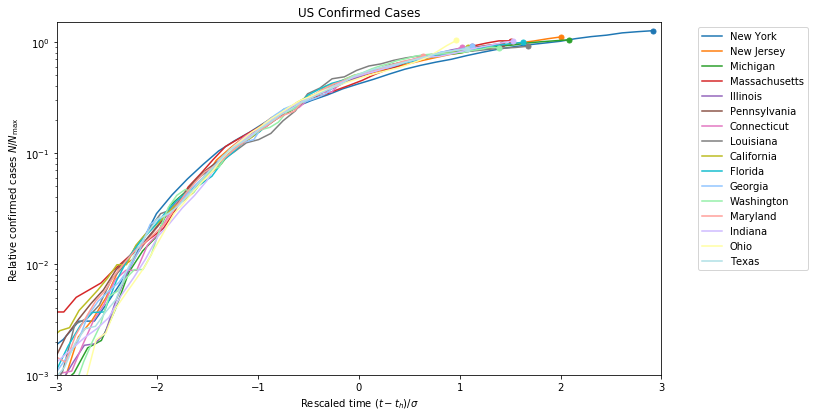

In [4]:
plot_collapse(params_deaths,params_cases)

The next cell computes 95 percent confidence intervals for all countries and regions, following the method described in the manuscript. As noted above, the calculation assumes that the data is accurately described by the fitting function given above, with no changes in parameter values, and with all deviations from this function due to random multiplicative noise. The best-fit parameters and upper/lower bounds on the confidence interval are contained in the Pandas dataframes `predictions_deaths` and `predictions_cases`. Set `verbose` to `False` if you do not want each country's name to be printed as its predictions are generated. <em>Note that this cell takes about 10 minutes to run.</em>

In [6]:
predictions_deaths = predict_all(deaths,params_deaths,p0=50,verbose=True)
predictions_cases = predict_all(cases,params_cases,p0=500,verbose=True)

Sweden, NaN
Sweden, NaN


We can now look at the updated predictions for regions of interest:

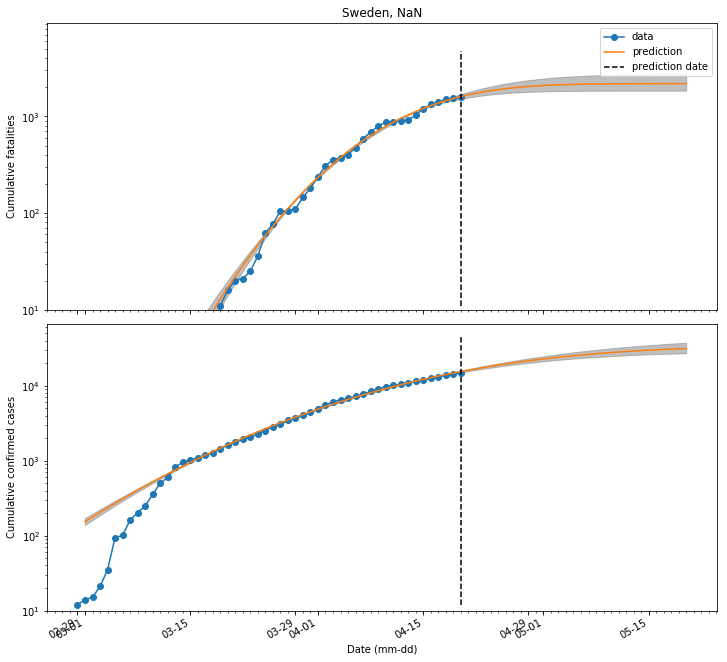

In [7]:
plot_region('Sweden','NaN',forecast_days=30,new_predictions=(predictions_deaths,predictions_cases)) 

# Run simulation

The following cell simulates disease spreading on a NetworkX graph `G` of your choice. When a node is infected, waiting times $T_g$ are randomly drawn for all neighboring nodes, and each neighbor is infected a time $T_g$ after the original node, if it is not already infected. The default distribution for drawing $T_g$ is a Gamma distribution, which is guaranteed to yield positive values. We parameterize the distribution by the mean $\mu_G$ and standard deviation $\sigma_G$. The Gamma distribution reduces to the exponential distribution (i.e., a Markovian spreading model) when these parameters are chosen such that $\mu_G = \sigma_G$. To reproduce the observed universal dynamics described by the cumulative normal distribution, it seems to be important to have $\mu_G \neq \sigma_G$, and to have a sufficiently heterogeneous degree distribution.

Time 2.742732211478553
Time 31.966164365549798


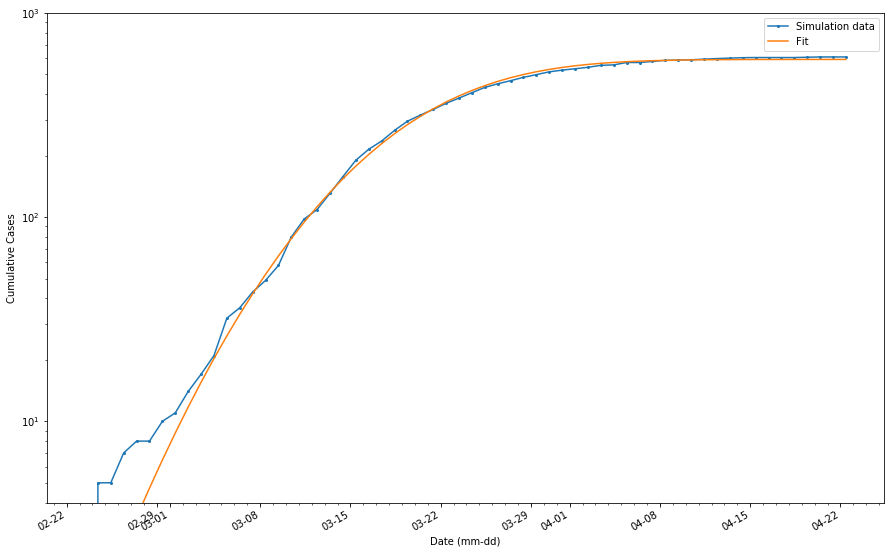

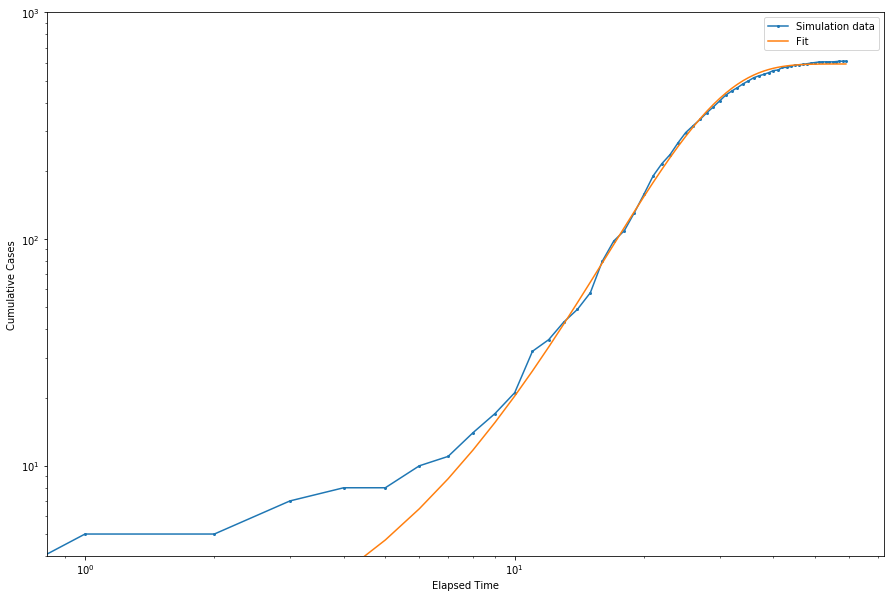

In [56]:
#Choose graph parameters
N=1000  #Number of nodes
gamma = 4 #For scale-free graphs
#k = 1.5 #Mean degree for Erdos-Renyi

#Make the graph
G = nx.expected_degree_graph(nx.utils.powerlaw_sequence(N, gamma), selfloops=False)
#G = nx.gnp_random_graph(N, k/N)

#Set up waiting time parameters
muG = 8 #Mean waiting time
sigG = 4 #standard deviation of waiting time

#Simulate
t,cum_cases = simulate_pandemic_edges(G,muG,sigG,tmax=60)

#Format like real data, and use same fitting script
t_dt = pd.to_datetime([datetime.today()-timedelta(days=int(np.max(t))-k) for k in range(int(np.max(t))+1)])
sim_data = pd.Series(cum_cases,index=t_dt)
th,logNmax,sigma,score = fit_erf(sim_data,p0=50)[0]

#Process output and plot
tau = ((t_dt-tref)/timedelta(days=1) - th)/sigma
Nmax = np.exp(logNmax)
fig,ax=plt.subplots(figsize=(15,10))
ax.semilogy(t_dt,sim_data.values,'o-',label='Simulation data',ms=2)
ax.semilogy(t_dt,Nmax*norm.cdf(tau),label='Fit')
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlabel('Date (mm-dd)')
ax.set_ylim((4,N))
ax.set_ylabel('Cumulative Cases')
fig.autofmt_xdate()
ax.legend()
plt.show()

#Also plot on log-log axes
fig,ax=plt.subplots(figsize=(15,10))
ax.loglog(t,sim_data.values,'o-',label='Simulation data',ms=2)
ax.loglog(t,Nmax*norm.cdf(tau),label='Fit')
ax.set_xlabel('Elapsed Time')
ax.set_ylim((4,N))
ax.set_ylabel('Cumulative Cases')
ax.legend()
plt.show()